## EDA - Exploratory Data Analysis

In [1]:
# Check directories and files
import os

print("Verificando diretórios:")
print("/app existe:", os.path.exists("/app"))
print("/app/datalake existe:", os.path.exists("/app/datalake"))
print("/app/datalake/silver existe:", os.path.exists("/app/datalake/silver"))
print("/app/datalake/silver/treino existe:", os.path.exists("/app/datalake/silver/treino"))
print("/app/datalake/silver/itens existe:", os.path.exists("/app/datalake/silver/itens"))

if os.path.exists("/app/datalake/silver"):
    print("\nConteúdo de /app/datalake/silver:")
    print(os.listdir("/app/datalake/silver"))

Verificando diretórios:
/app existe: True
/app/datalake existe: True
/app/datalake/silver existe: True
/app/datalake/silver/treino existe: True
/app/datalake/silver/itens existe: True

Conteúdo de /app/datalake/silver:
['itens', 'treino']


In [1]:
# Start Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("Silver Data Exploration") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.default.parallelism", "12") \
    .config("spark.sql.shuffle.partitions", "12") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.files.maxPartitionBytes", "128m") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.service.enabled", "true") \
    .config("spark.locality.wait", "0s") \
    .getOrCreate()



In [2]:
# Read data (note the correct path for mapped volume)
treino = spark.read \
    .option("mergeSchema", "false") \
    .parquet("/app/datalake/silver/treino") \
    .coalesce(2)

In [3]:
itens = spark.read \
    .option("mergeSchema", "false") \
    .parquet("/app/datalake/silver/itens") \
    .coalesce(2)

In [4]:
# Create temporary tables for SQL
treino.createOrReplaceTempView("tab_treino")
itens.createOrReplaceTempView("tab_itens")


In [5]:
# Show record counts
print("Número de registros em treino:", treino.count())
print("Número de registros em itens:", itens.count())

# Show data schema
print("\nSchema dos dados de treino:")
treino.printSchema()

print("\nSchema dos dados de itens:")
itens.printSchema()

Número de registros em treino: 8123951
Número de registros em itens: 255603

Schema dos dados de treino:
root
 |-- userId: string (nullable = true)
 |-- userType: string (nullable = true)
 |-- history: string (nullable = true)
 |-- timestampHistory: string (nullable = true)
 |-- numberOfClicksHistory: integer (nullable = true)
 |-- timeOnPageHistory: integer (nullable = true)
 |-- scrollPercentageHistory: float (nullable = true)
 |-- pageVisitsCountHistory: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)


Schema dos dados de itens:
root
 |-- page: string (nullable = true)
 |-- issued: timestamp (nullable = true)
 |-- modified: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- body: string (nullable = true)
 |-- caption: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)



In [7]:
# SQL query
results = spark.sql("""
    SELECT min(timestampHistory) as min_timestamp, 
           max(timestampHistory) as max_timestamp
    FROM tab_treino
""")

results.show(truncate=False)

+-------------------+-------------------+
|min_timestamp      |max_timestamp      |
+-------------------+-------------------+
|2022-07-01 03:00:00|2022-08-15 02:59:47|
+-------------------+-------------------+



In [8]:
# Basic analysis
print("\nDistribuição de userType:")
treino.groupBy("userType").count().show()

print("\nEstatísticas de timeOnPageHistory:")
treino.select("timeOnPageHistory").describe().show()


Distribuição de userType:
+----------+-------+
|  userType|  count|
+----------+-------+
|    Logged|3676649|
|Non-Logged|4447302|
+----------+-------+


Estatísticas de timeOnPageHistory:
+-------+------------------+
|summary| timeOnPageHistory|
+-------+------------------+
|  count|           8123951|
|   mean| 88768.68892008334|
| stddev|113932.18035809962|
|    min|              5000|
|    max|          46033049|
+-------+------------------+



In [9]:
# Análise temporal dos dados
print("Análise temporal:")
print("\nPeríodo dos dados:")
print(f"Data mais antiga: {treino.select(min('timestampHistory')).collect()[0][0]}")
print(f"Data mais recente: {treino.select(max('timestampHistory')).collect()[0][0]}")

# Distribuição de acessos por hora do dia
treino.createOrReplaceTempView("temporal_analysis")
hourly_distribution = spark.sql("""
    SELECT HOUR(timestampHistory) as hour,
           COUNT(*) as count
    FROM temporal_analysis
    GROUP BY HOUR(timestampHistory)
    ORDER BY hour
""")
hourly_distribution.show()

Análise temporal:

Período dos dados:
Data mais antiga: 2022-07-01 03:00:00
Data mais recente: 2022-08-15 02:59:47
+----+------+
|hour| count|
+----+------+
|   0|320015|
|   1|288388|
|   2|224146|
|   3|151451|
|   4| 91916|
|   5| 62133|
|   6| 50889|
|   7| 51730|
|   8| 81095|
|   9|161499|
|  10|303653|
|  11|486262|
|  12|544881|
|  13|558819|
|  14|548751|
|  15|476872|
|  16|533372|
|  17|555973|
|  18|542704|
|  19|528459|
+----+------+
only showing top 20 rows



In [10]:
# Análise de engajamento
print("Métricas de engajamento:")
engagement_metrics = spark.sql("""
    SELECT 
        AVG(timeOnPageHistory) as avg_time_on_page,
        AVG(scrollPercentageHistory) as avg_scroll_percentage,
        AVG(numberOfClicksHistory) as avg_clicks,
        AVG(pageVisitsCountHistory) as avg_visits
    FROM tab_treino
""")
engagement_metrics.show()

Métricas de engajamento:
+-----------------+---------------------+------------------+------------------+
| avg_time_on_page|avg_scroll_percentage|        avg_clicks|        avg_visits|
+-----------------+---------------------+------------------+------------------+
|88768.68892008334|    54.00550788550375|12.053645695302691|1.1365660624984075|
+-----------------+---------------------+------------------+------------------+



In [11]:
# Análise dos itens
print("Análise do conteúdo:")
print("\nDistribuição temporal das notícias:")
item_temporal = spark.sql("""
    SELECT 
        DATE(issued) as publication_date,
        COUNT(*) as article_count
    FROM tab_itens
    GROUP BY DATE(issued)
    ORDER BY publication_date
""")
item_temporal.show()

Análise do conteúdo:

Distribuição temporal das notícias:
+----------------+-------------+
|publication_date|article_count|
+----------------+-------------+
|      2014-07-31|            1|
|      2015-01-12|            1|
|      2015-06-30|            8|
|      2015-09-23|            1|
|      2015-11-17|            1|
|      2015-12-01|            2|
|      2015-12-04|            1|
|      2015-12-29|           22|
|      2015-12-31|            1|
|      2016-01-12|            1|
|      2016-01-18|            2|
|      2016-04-28|            1|
|      2016-05-10|            1|
|      2016-05-13|            1|
|      2016-05-16|            1|
|      2016-05-21|            1|
|      2016-05-23|            1|
|      2016-05-24|            1|
|      2016-05-26|            1|
|      2016-05-27|            1|
+----------------+-------------+
only showing top 20 rows



In [12]:
# Análise do histórico de leitura (corrigido)
history_size_dist = spark.sql("""
    SELECT 
        history,
        COUNT(*) as count
    FROM tab_treino
    GROUP BY history
    ORDER BY count DESC
    LIMIT 10
""")
print("Top 10 históricos mais frequentes:")
history_size_dist.show(truncate=False)

Top 10 históricos mais frequentes:
+------------------------------------+-----+
|history                             |count|
+------------------------------------+-----+
|d2593c3d-2347-40d9-948c-b6065e8459a9|25075|
|f6b5d170-48b9-4f8e-88d4-c84b6668f3bd|22179|
|1f32787b-de2b-49be-8c20-ddaeae34cc22|19519|
|f0a78e58-ec7e-494c-9462-fbd6446a9a89|18361|
|6a83890a-d9e9-4f6b-a6c6-90d031785bbf|18101|
|855d20b7-53f2-4678-a10f-55402d085018|17105|
|4c63d7cd-4902-4ffb-9b94-578b1b2151f0|16758|
|1c27cf97-b20c-4e40-b1f1-288b721517b3|16428|
|bf257382-74fb-4392-ad6a-143240e39f81|16405|
|a36c98b5-f159-48f8-9f5a-1fc6ea9956c8|15885|
+------------------------------------+-----+



In [6]:
# Análise de engajamento por tipo de usuário
user_engagement = spark.sql("""
    SELECT 
        userType,
        AVG(timeOnPageHistory) as avg_time_on_page,
        AVG(scrollPercentageHistory) as avg_scroll_percentage,
        AVG(numberOfClicksHistory) as avg_clicks,
        AVG(pageVisitsCountHistory) as avg_visits,
        COUNT(DISTINCT userId) as user_count
    FROM tab_treino
    GROUP BY userType
""")
print("Métricas de engajamento por tipo de usuário:")
user_engagement.show()

Métricas de engajamento por tipo de usuário:
+----------+-----------------+---------------------+------------------+------------------+----------+
|  userType| avg_time_on_page|avg_scroll_percentage|        avg_clicks|        avg_visits|user_count|
+----------+-----------------+---------------------+------------------+------------------+----------+
|    Logged|85826.12160747463|    55.57238991440847|12.835719428207588|1.1580708411382212|    119086|
|Non-Logged|91201.35195203744|    52.71014380978087|11.407094008906974|  1.11878775041587|    458856|
+----------+-----------------+---------------------+------------------+------------------+----------+



In [14]:
# Análise da recência das notícias
news_recency = spark.sql("""
    SELECT 
        DATE(issued) as publication_date,
        COUNT(*) as article_count,
        AVG(DATEDIFF(modified, issued)) as avg_days_until_modification
    FROM tab_itens
    GROUP BY DATE(issued)
    ORDER BY publication_date DESC
    LIMIT 10
""")
print("Análise de recência das notícias (últimos 10 dias):")
news_recency.show()

Análise de recência das notícias (últimos 10 dias):
+----------------+-------------+---------------------------+
|publication_date|article_count|avg_days_until_modification|
+----------------+-------------+---------------------------+
|      2022-08-15|           20|                       1.95|
|      2022-08-14|          412|          3.662621359223301|
|      2022-08-13|          493|          4.557809330628803|
|      2022-08-12|          869|          3.344073647871116|
|      2022-08-11|          889|         2.8650168728908887|
|      2022-08-10|          917|         2.2977099236641223|
|      2022-08-09|          890|         1.9629213483146069|
|      2022-08-08|          864|          1.849537037037037|
|      2022-08-07|          438|         0.9794520547945206|
|      2022-08-06|          544|         1.3143382352941178|
+----------------+-------------+---------------------------+



In [7]:
# Análise de interações usuário-conteúdo
user_content_patterns = spark.sql("""
    SELECT 
        userId,
        COUNT(DISTINCT history) as unique_articles_read,
        AVG(timeOnPageHistory) as avg_reading_time,
        MAX(pageVisitsCountHistory) as max_visits_to_single_article
    FROM tab_treino
    GROUP BY userId
    ORDER BY unique_articles_read DESC
    LIMIT 10
""")
print("Top 10 usuários mais ativos:")
user_content_patterns.show()

Top 10 usuários mais ativos:
+--------------------+--------------------+------------------+----------------------------+
|              userId|unique_articles_read|  avg_reading_time|max_visits_to_single_article|
+--------------------+--------------------+------------------+----------------------------+
|1b9bf55cf5c0d7ba3...|                7004|10863.709023415191|                           9|
|1f7a8e71d6d871e6a...|                5907| 36989.88251227357|                           9|
|83a2ba48f07e49f33...|                4914|44673.198209198206|                           9|
|d3b82a1305105bcaa...|                3580|  83962.5312849162|                           9|
|9d176e2202250e792...|                3318| 163915.2112718505|                           4|
|457cfacfd37c50ed3...|                2980|128595.01275167786|                           9|
|7b4b38431563fb0f4...|                2939|  22198.6070091868|                           2|
|d6eb2b74526fc5aa7...|                2801|112511.5

### Análise Visual da Distribuição Temporal
Vamos visualizar os padrões temporais de leitura para entender quando os usuários mais consomem conteúdo.


/tmp/ipykernel_130/350883318.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, 'Número de Leituras')

<Figure size 1500x1000 with 0 Axes>

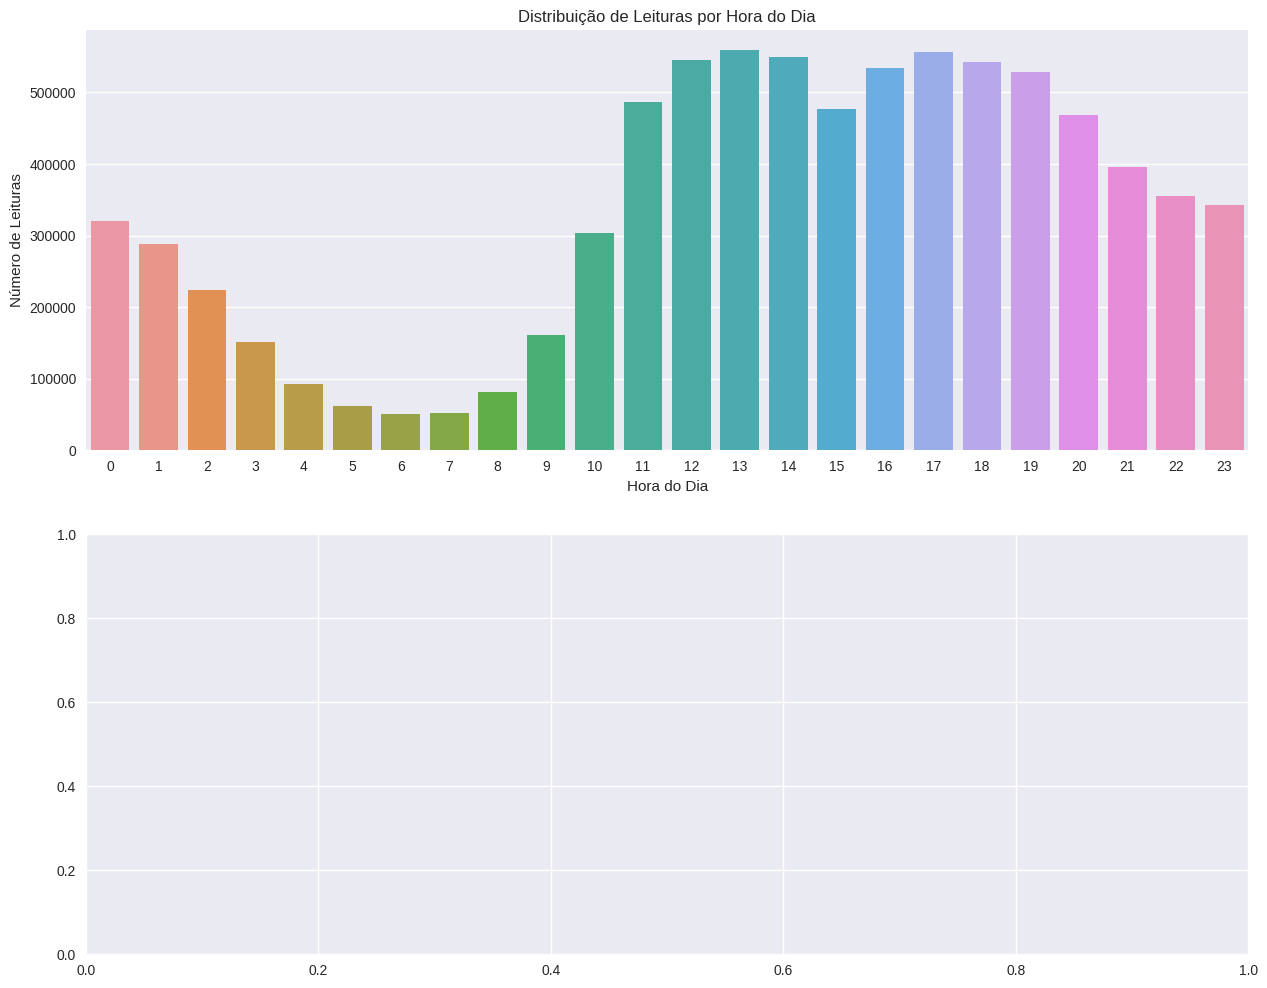

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
plt.style.use('seaborn')
plt.figure(figsize=(15, 10))

# Criar subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 1. Distribuição por hora do dia
hourly_dist = spark.sql("""
    SELECT HOUR(timestampHistory) as hour,
           COUNT(*) as count
    FROM tab_treino
    GROUP BY HOUR(timestampHistory)
    ORDER BY hour
""").toPandas()

sns.barplot(data=hourly_dist, x='hour', y='count', ax=ax1)
ax1.set_title('Distribuição de Leituras por Hora do Dia')
ax1.set_xlabel('Hora do Dia')
ax1.set_ylabel('Número de Leituras')

In [17]:
# 2. Distribuição por dia da semana
daily_dist = spark.sql("""
    SELECT DAYOFWEEK(timestampHistory) as day,
           COUNT(*) as count
    FROM tab_treino
    GROUP BY DAYOFWEEK(timestampHistory)
    ORDER BY day
""").toPandas()

sns.barplot(data=daily_dist, x='day', y='count', ax=ax2)
ax2.set_title('Distribuição de Leituras por Dia da Semana')
ax2.set_xlabel('Dia da Semana (1=Domingo, 7=Sábado)')
ax2.set_ylabel('Número de Leituras')

plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

### Análise de Engajamento do Usuário
Visualização da relação entre diferentes métricas de engajamento para identificar padrões de comportamento.


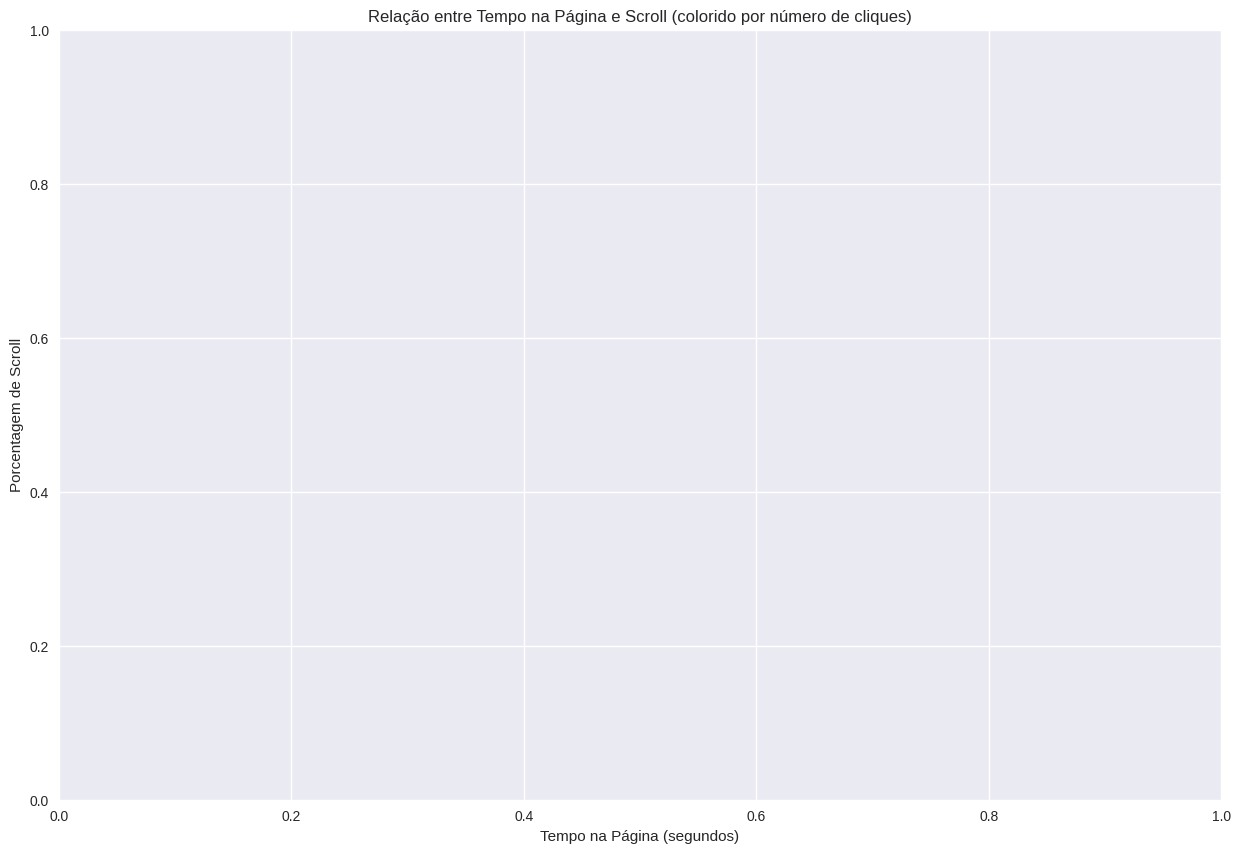

In [18]:
plt.figure(figsize=(15, 10))

# Criar scatter plot com densidade de pontos
engagement_data = spark.sql("""
    SELECT timeOnPageHistory, scrollPercentageHistory, numberOfClicksHistory
    FROM tab_treino
    WHERE timeOnPageHistory < 1000  -- Remove outliers
""").toPandas()

sns.scatterplot(
    data=engagement_data,
    x='timeOnPageHistory',
    y='scrollPercentageHistory',
    hue='numberOfClicksHistory',
    alpha=0.5
)

plt.title('Relação entre Tempo na Página e Scroll (colorido por número de cliques)')
plt.xlabel('Tempo na Página (segundos)')
plt.ylabel('Porcentagem de Scroll')
plt.show()


### Análise de Recência das Notícias
Visualização da distribuição de idade das notícias e seu impacto no engajamento.


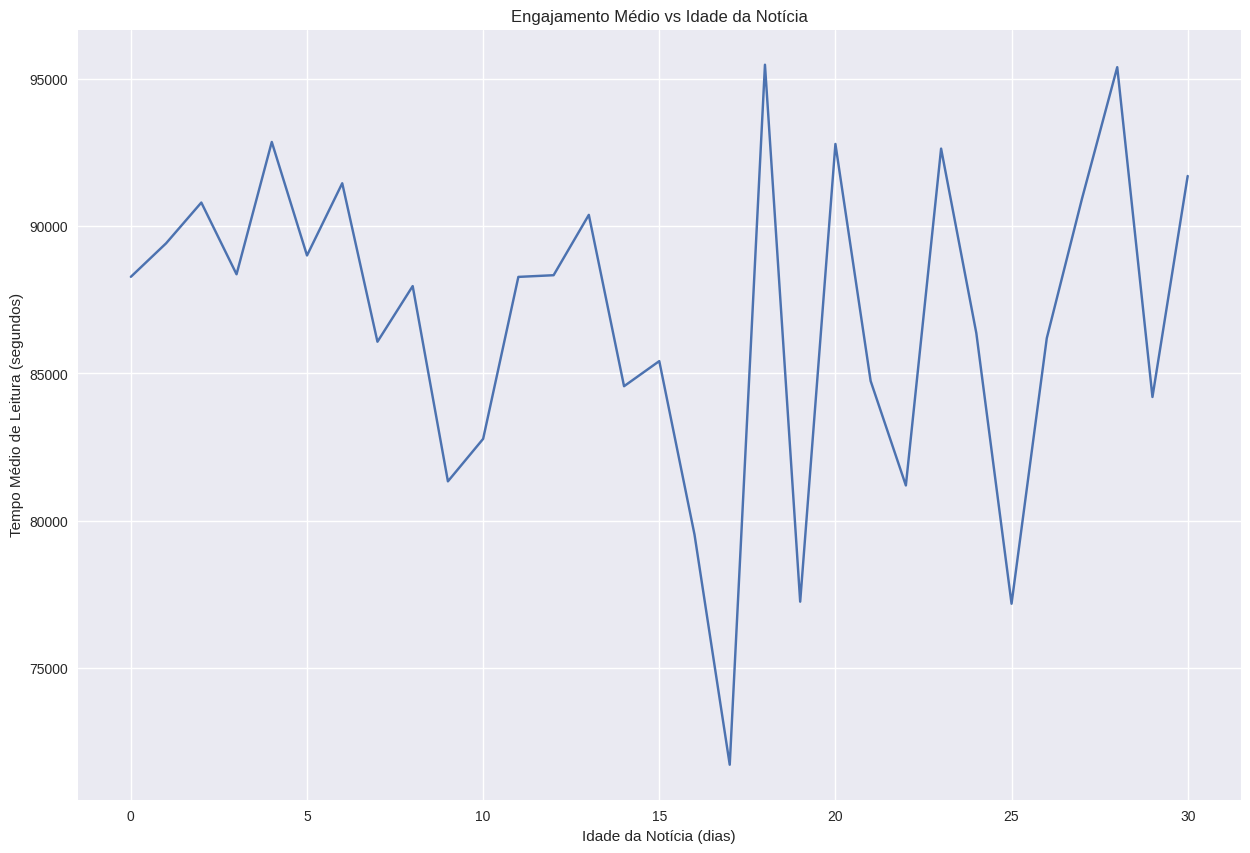

In [19]:
plt.figure(figsize=(15, 10))

# Calcular idade das notícias e engajamento médio
news_age_engagement = spark.sql("""
    SELECT 
        DATEDIFF(modified, issued) as news_age,
        AVG(timeOnPageHistory) as avg_engagement
    FROM tab_treino
    JOIN tab_itens ON history = page
    GROUP BY DATEDIFF(modified, issued)
    HAVING news_age >= 0 AND news_age <= 30
    ORDER BY news_age
""").toPandas()

sns.lineplot(
    data=news_age_engagement,
    x='news_age',
    y='avg_engagement'
)

plt.title('Engajamento Médio vs Idade da Notícia')
plt.xlabel('Idade da Notícia (dias)')
plt.ylabel('Tempo Médio de Leitura (segundos)')
plt.show()


### Análise de Usuários
Visualização dos padrões de comportamento por tipo de usuário.


Text(0.5, 1.0, 'Distribuição por Tipo de Usuário')

<Figure size 1500x1200 with 0 Axes>

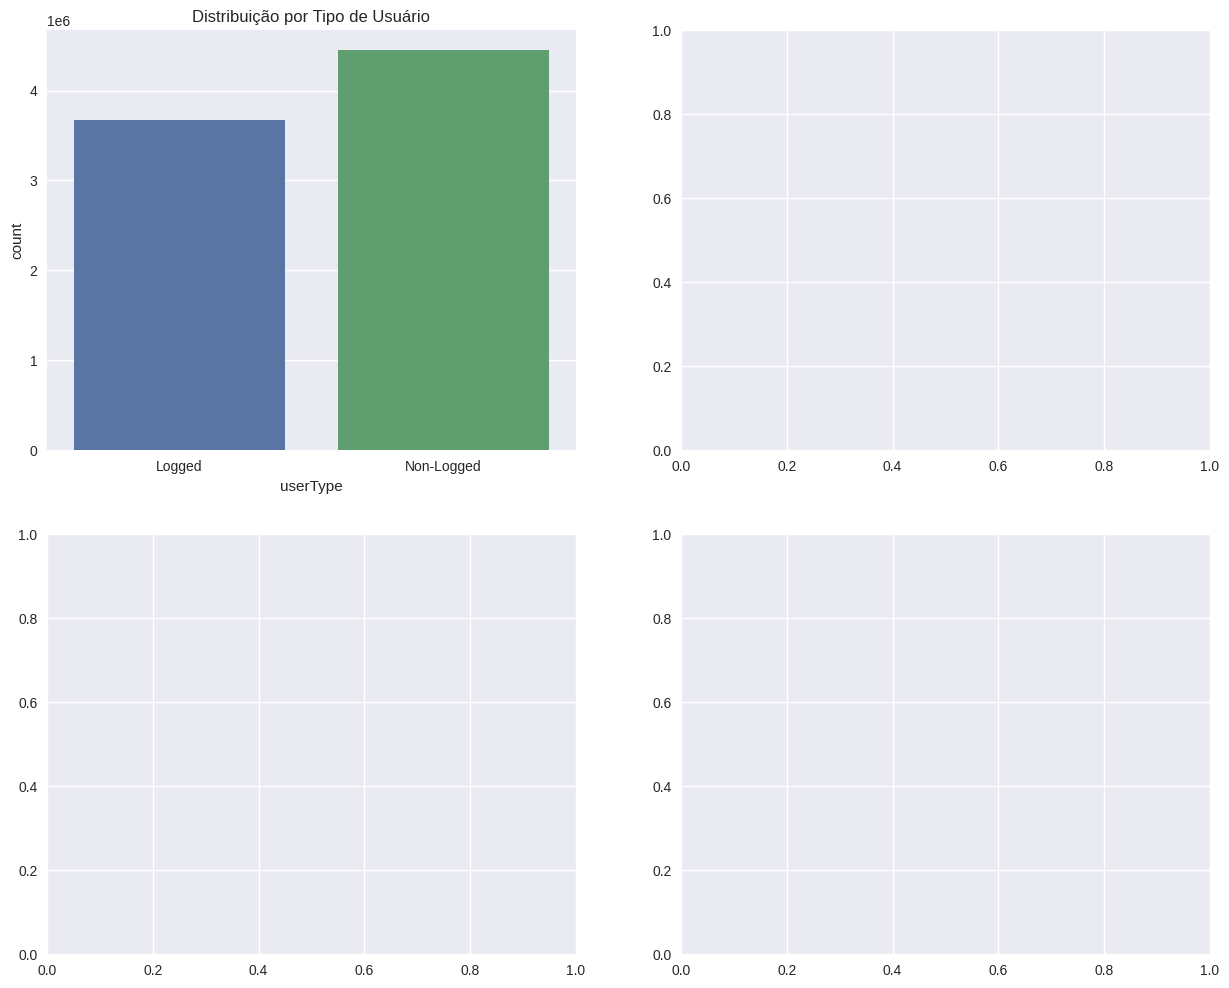

In [20]:
plt.figure(figsize=(15, 12))

# Criar subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuição de tipos de usuário
user_type_dist = spark.sql("""
    SELECT userType, COUNT(*) as count
    FROM tab_treino
    GROUP BY userType
""").toPandas()

sns.barplot(data=user_type_dist, x='userType', y='count', ax=ax1)
ax1.set_title('Distribuição por Tipo de Usuário')


In [21]:
# 2. Tempo médio na página por tipo de usuário
time_by_type = spark.sql("""
    SELECT userType, AVG(timeOnPageHistory) as avg_time
    FROM tab_treino
    GROUP BY userType
""").toPandas()

sns.barplot(data=time_by_type, x='userType', y='avg_time', ax=ax2)
ax2.set_title('Tempo Médio na Página por Tipo de Usuário')


Text(0.5, 1.0, 'Tempo Médio na Página por Tipo de Usuário')

In [22]:
# 3. Distribuição do tamanho do histórico
history_dist = spark.sql("""
    SELECT historySize, COUNT(*) as count
    FROM tab_treino
    GROUP BY historySize
    ORDER BY historySize
""").toPandas()

sns.histplot(data=history_dist, x='historySize', y='count', ax=ax3)
ax3.set_title('Distribuição do Tamanho do Histórico')


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `historySize` cannot be resolved. Did you mean one of the following? [`history`, `userId`, `userType`, `day`, `month`].; line 2 pos 11;
'Sort ['historySize ASC NULLS FIRST], true
+- 'Aggregate ['historySize], ['historySize, count(1) AS count#611L]
   +- SubqueryAlias tab_treino
      +- View (`tab_treino`, [userId#0,userType#1,history#2,timestampHistory#3,numberOfClicksHistory#4,timeOnPageHistory#5,scrollPercentageHistory#6,pageVisitsCountHistory#7,year#8,month#9,day#10])
         +- Repartition 2, false
            +- Relation [userId#0,userType#1,history#2,timestampHistory#3,numberOfClicksHistory#4,timeOnPageHistory#5,scrollPercentageHistory#6,pageVisitsCountHistory#7,year#8,month#9,day#10] parquet


In [ ]:
# 4. Engajamento médio por tamanho do histórico
engagement_by_history = spark.sql("""
    SELECT 
        historySize,
        AVG(timeOnPageHistory) as avg_engagement
    FROM tab_treino
    GROUP BY historySize
    ORDER BY historySize
""").toPandas()

sns.lineplot(data=engagement_by_history, x='historySize', y='avg_engagement', ax=ax4)
ax4.set_title('Engajamento vs Tamanho do Histórico')

plt.tight_layout()
plt.show()